In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset 
from sklearn.model_selection import train_test_split

from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [2]:
!nvidia-smi

Wed May 29 06:53:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**`Torch Dataset` для нашего датасета**

In [3]:
class MedicalImageDataset(Dataset):
    def __init__(self, img_dir, data='train', transform=None):
        super().__init__()
        self.img_dir = img_dir,
        self.data = data
        self.labels = torch.load(f'{img_dir}/{data}/labels.pt')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx): 
        image = read_image(f'{self.img_dir[0]}/{self.data}/images/({idx})-img.jpg') / 255
        if self.transform:
            image = self.transform(image)
            
        return (image, self.labels[idx])

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_val_dataset = MedicalImageDataset(
    img_dir=f'../input',
    data='train',
    transform=preprocess
)

test_dataset = MedicalImageDataset(
    img_dir=f'../input',
    data='test', 
    transform=preprocess
)

train_idx, val_idx = train_test_split(np.arange(len(train_val_dataset)), test_size=0.2, shuffle=True, random_state=0)

train_dataset = Subset(train_val_dataset, train_idx)
val_dataset = Subset(train_val_dataset, val_idx)

**Преобразуем в `Torch Dataloader`, чтобы перемешивать данные и разбивать их на батчи**

In [5]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.float32


**Определяем, на каком устройстве будем обучать нейросеть**

In [6]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


**Функции для обучения и теста нейросети**

In [7]:
def train(dataloader, model, criterion, optimizer, scheduler, epoch, num_epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    len_batch = dataloader.batch_size
    
    model.train()    
    loss_avg, accuracy_avg = 0, 0   
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.long())
        accuracy = (predictions.argmax(1) == y_batch).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
        accuracy_avg += accuracy
        
    if scheduler is not None:
        scheduler.step()

    return loss_avg / num_batches, accuracy_avg / size
        
        
def test(dataloader, model, criterion, epoch, num_epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()   
    with torch.no_grad():
        loss_avg, accuracy_avg = 0, 0
        
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            predictions = model(X_batch)
            loss_avg += criterion(predictions, y_batch.long()).item()
            accuracy_avg += (predictions.argmax(1) == y_batch).type(torch.float).sum().item()
            
    return loss_avg / num_batches, accuracy_avg / size

### Пробуем готовые архитектуры

**ConvNeXt (Tiny)**

In [10]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights).to(device)
model.classifier[2] = nn.Linear(768, 23).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # , momentum=0.9, weight_decay=0.0005
# scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 30

train_loss, train_accuracy = (np.zeros(num_epochs), np.zeros(num_epochs))
val_loss, val_accuracy = (np.zeros(num_epochs), np.zeros(num_epochs))

for epoch in range(num_epochs):
    train_loss[epoch], train_accuracy[epoch] = train(train_dataloader, model, criterion, optimizer, scheduler, epoch, num_epochs)
    val_loss[epoch], val_accuracy[epoch] = test(val_dataloader, model, criterion, epoch, num_epochs)
    
    print(f'\n>>> Epoch {epoch+1}\n\tTrain\tloss: {train_loss[epoch]:.4f},  accuracy: {100 * train_accuracy[epoch]:.2f}')
    print(f'\tVal  \tloss: {val_loss[epoch]:.4f},  accuracy: {100 * val_accuracy[epoch]:.2f}')

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 61.5MB/s]



>>> Epoch 1
	Train	loss: 1.7328,  accuracy: 49.10
	Val  	loss: 1.1169,  accuracy: 66.09

>>> Epoch 2
	Train	loss: 0.6418,  accuracy: 81.10
	Val  	loss: 0.6383,  accuracy: 81.27

>>> Epoch 3
	Train	loss: 0.2775,  accuracy: 92.01
	Val  	loss: 0.8428,  accuracy: 77.08

>>> Epoch 4
	Train	loss: 0.2624,  accuracy: 91.80
	Val  	loss: 0.6804,  accuracy: 82.41

>>> Epoch 5
	Train	loss: 0.1918,  accuracy: 93.90
	Val  	loss: 0.6040,  accuracy: 83.00

>>> Epoch 6
	Train	loss: 0.0760,  accuracy: 97.58
	Val  	loss: 0.4635,  accuracy: 87.73

>>> Epoch 7
	Train	loss: 0.0437,  accuracy: 98.37
	Val  	loss: 0.4410,  accuracy: 88.35

>>> Epoch 8
	Train	loss: 0.0398,  accuracy: 98.45
	Val  	loss: 0.4447,  accuracy: 88.34

>>> Epoch 9
	Train	loss: 0.0389,  accuracy: 98.48
	Val  	loss: 0.5076,  accuracy: 87.84

>>> Epoch 10
	Train	loss: 0.0425,  accuracy: 98.43
	Val  	loss: 0.5592,  accuracy: 87.16

>>> Epoch 11
	Train	loss: 0.0325,  accuracy: 98.56
	Val  	loss: 0.5162,  accuracy: 88.17

>>> Epoch 12
	Trai

**Строим графики**

In [11]:
# функция для настройки графиков (названия, оси, сетка, шрифт)

def plot_settings(ax, title, xlabel, ylabel):
    font_title = {'family': 'Comic Sans MS', 'color': 'black', 'size': 22}
    font_labels = {'family': 'Times New Roman', 'color': 'black', 'size': 20}
    font_ticks = {'family': 'Times New Roman', 'color': 'black', 'size': 16}
    
    ax.set_xlabel(xlabel, fontdict=font_labels)
    ax.set_ylabel(ylabel, fontdict=font_labels)
    ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)
    ax.grid(color='gray', linestyle='--', linewidth=0.25)
    ax.set_title(label=title, fontdict=font_title)
    ax.legend()

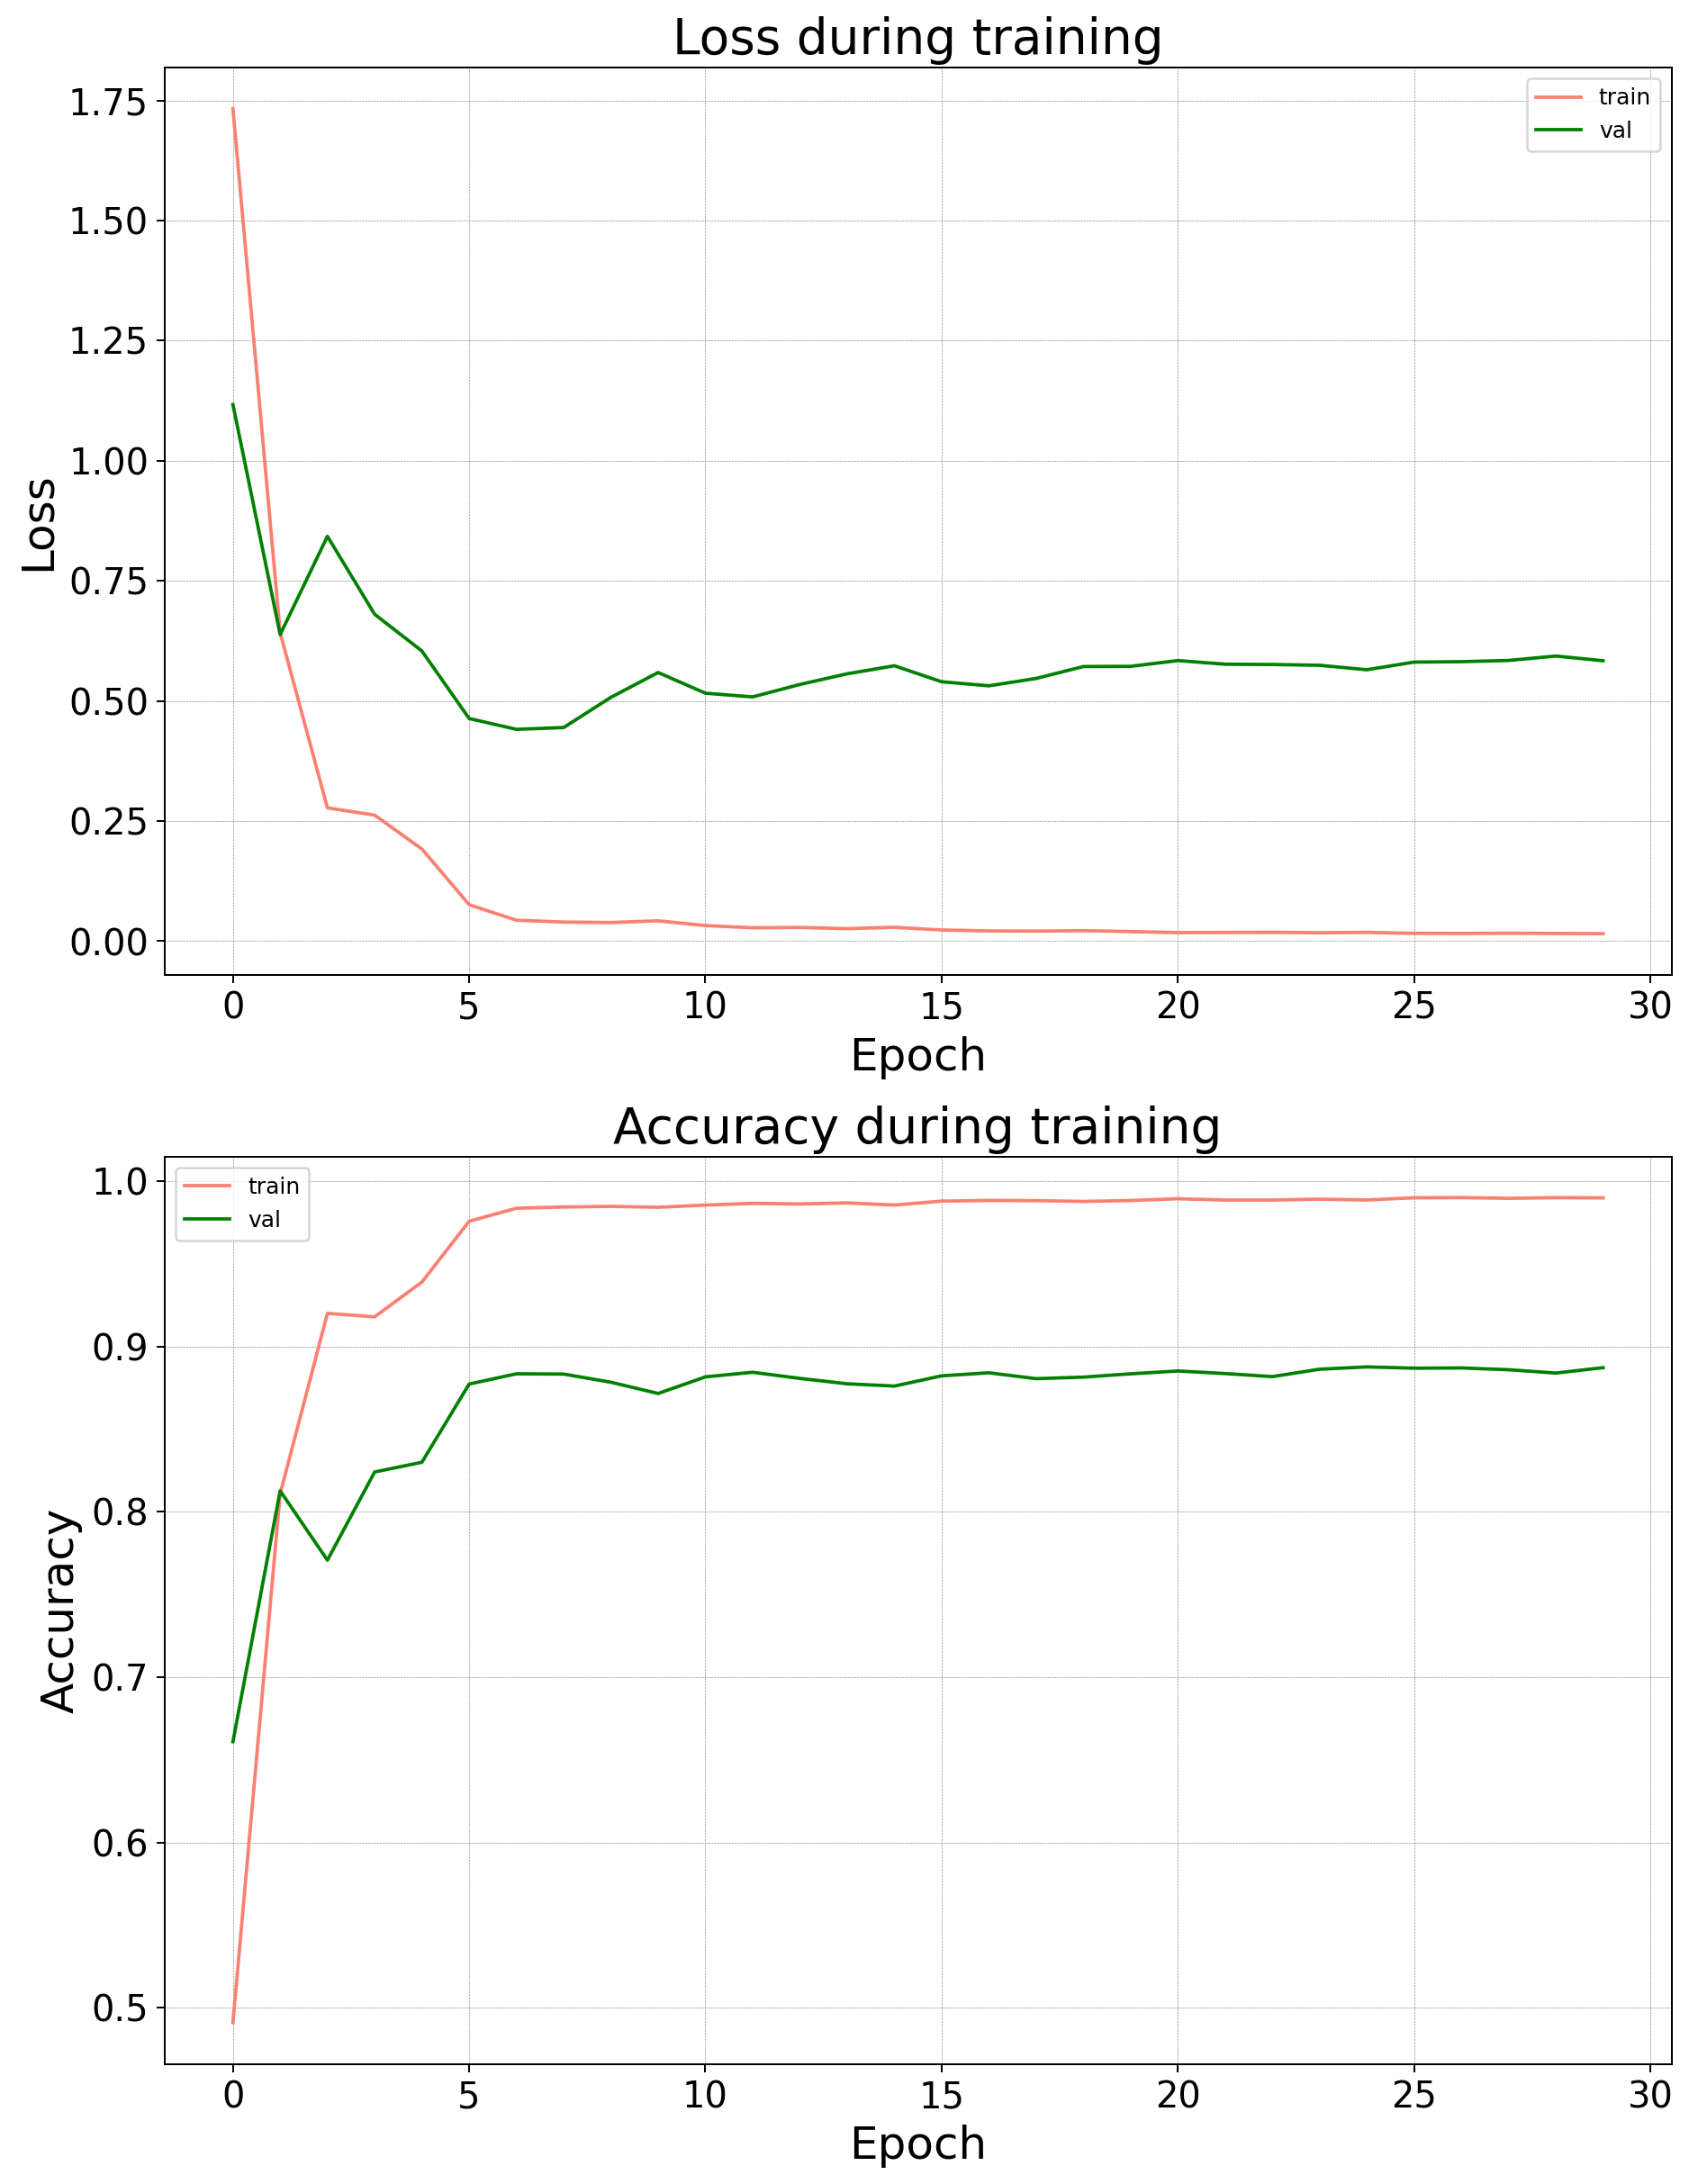

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16), dpi=180)

ax[0].plot(train_loss, color='salmon', label='train')
ax[0].plot(val_loss, color='green', label='val')
plot_settings(ax=ax[0], title='Loss during training', xlabel='Epoch', ylabel='Loss')

ax[1].plot(train_accuracy, color='salmon', label='train')
ax[1].plot(val_accuracy, color='green', label='val')
plot_settings(ax=ax[1], title='Accuracy during training', xlabel='Epoch', ylabel='Accuracy')

plt.show()

**Функция вывода метрик на тестовой выборке**

In [13]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, AveragePrecision

torch.manual_seed(123)


def test_metrics(dataloader, model, task='multiclass', num_classes=23):
    model.eval()
    size = len(dataloader.dataset)
    
    # микро-усреднение
    metrics_accuracy_micro = Accuracy(task=task, num_classes=num_classes, average='micro').to(device)
    metrics_precision_micro = Precision(task=task, num_classes=num_classes, average='micro').to(device)
    metrics_recall_micro = Recall(task=task, num_classes=num_classes, average='micro').to(device)
    metrics_f1score_micro = F1Score(task=task, num_classes=num_classes, average='micro').to(device)
    
    # макро-усреднение
    metrics_accuracy_macro = Accuracy(task=task, num_classes=num_classes, average='macro').to(device)
    metrics_precision_macro = Precision(task=task, num_classes=num_classes, average='macro').to(device)
    metrics_recall_macro = Recall(task=task, num_classes=num_classes, average='macro').to(device)
    metrics_f1score_macro = F1Score(task=task, num_classes=num_classes, average='macro').to(device)
    metrics_aucroc_macro = AUROC(task=task, num_classes=num_classes, average='macro').to(device)
    metric_aucpr_macro = AveragePrecision(task=task, num_classes=num_classes, average='macro').to(device)
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            
            # микро-усреднение
            accuracy_micro = metrics_accuracy_micro(predictions, y_batch)
            precision_micro = metrics_precision_micro(predictions, y_batch)
            recall_micro = metrics_recall_micro(predictions, y_batch)
            f1score_micro = metrics_f1score_micro(predictions, y_batch)
            
            # макро-усреднение
            accuracy_mаcro = metrics_accuracy_macro(predictions, y_batch)
            aucroc_mаcro = metrics_aucroc_macro(predictions, y_batch.int())
            precision_mаcro = metrics_precision_macro(predictions, y_batch)
            recall_mаcro = metrics_recall_macro(predictions, y_batch)
            f1score_macro = metrics_f1score_macro(predictions, y_batch)
            aucpr_macro = metric_aucpr_macro(predictions, y_batch.int())
            
        # микро-усреднение
        accuracy_micro = metrics_accuracy_micro.compute()
        precision_micro = metrics_precision_micro.compute()
        recall_micro = metrics_recall_micro.compute()
        f1score_micro = metrics_f1score_micro.compute()
        
        # макро-усреднение
        accuracy_macro = metrics_accuracy_macro.compute()
        aucroc_macro = metrics_aucroc_macro.compute()
        precision_macro = metrics_precision_macro.compute()
        recall_macro = metrics_recall_macro.compute()
        f1score_macro = metrics_f1score_macro.compute()
        aucpr_macro = metric_aucpr_macro.compute()
        
        print(f'Result metrics for test dataset')
        # микро-усреднение
        print(f'\n>>> Average - MICRO')
        print(f'\tAccuracy:  {accuracy_micro:.2f}')
        print(f'\tPrecision: {precision_micro:.2f}')
        print(f'\tRecall:    {recall_micro:.2f}')
        print(f'\tF1 Score:  {f1score_micro:.2f}')
        
        # макро-усреднение
        print(f'\n>>> Average - MACRO')
        print(f'\tAccuracy:  {accuracy_macro:.2f}')
        print(f'\tPrecision: {precision_macro:.2f}')
        print(f'\tRecall:    {recall_macro:.2f}')
        print(f'\tF1 Score:  {f1score_macro:.2f}')
        print(f'\tAUC-ROC:   {aucroc_macro:.2f}')
        print(f'\tAUC-PR:    {aucpr_macro:.2f}')

**Смотрим метрики**

In [14]:
test_metrics(test_dataloader, model)

Result metrics for test dataset

>>> Average - MICRO
	Accuracy:  0.66
	Precision: 0.66
	Recall:    0.66
	F1 Score:  0.66

>>> Average - MACRO
	Accuracy:  0.62
	Precision: 0.65
	Recall:    0.62
	F1 Score:  0.63
	AUC-ROC:   0.95
	AUC-PR:    0.68


**Сохраняем модель**

In [15]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
